In [ ]:
# # Run this cell if you haven't installed yahoo finance library
# pip install yfinance

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout

In [6]:
#Define ticker and start date for stock
#End date is latest by default

ticker = 'GOOG' #stock
start_date = '2010-01-01'

# Fetch data
data = yf.download(ticker, start=start_date)
data.columns = [col[0] for col in data.columns]
td = data.iloc[:,1:2].values
# data.iloc[0:5,1:2]
# data.info()
td.shape

/tmp/ipython-input-1026522116.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)
ERROR:yfinance:Failed to get ticker 'GOOG' reason: Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[*********************100%***********************]  1 of 1 completed


(3938, 1)

In [7]:
print(data.head())
data.tail()

                Close       High        Low       Open     Volume
Date                                                             
2010-01-04  15.517998  15.586333  15.455851  15.522949   78541293
2010-01-05  15.449661  15.544985  15.389000  15.528643  120638494
2010-01-06  15.060196  15.495962  15.013153  15.495962  159744526
2010-01-07  14.709601  15.103277  14.673700  15.088422  257533695
2010-01-08  14.905696  14.936150  14.586051  14.657605  189680313


,Close,High,Low,Open,Volume
Date,,,,,
2025-08-22,206.720001,209.229996,202.130005,203.960007,25723700
2025-08-25,209.160004,211.089996,205.949997,207.000000,22788800
2025-08-26,207.949997,208.460007,206.449997,208.369995,23051000
2025-08-27,208.210007,209.570007,206.389999,206.460007,15249000
2025-08-28,212.369995,212.880005,207.600006,207.839996,16948014


<Axes: xlabel='Date'>

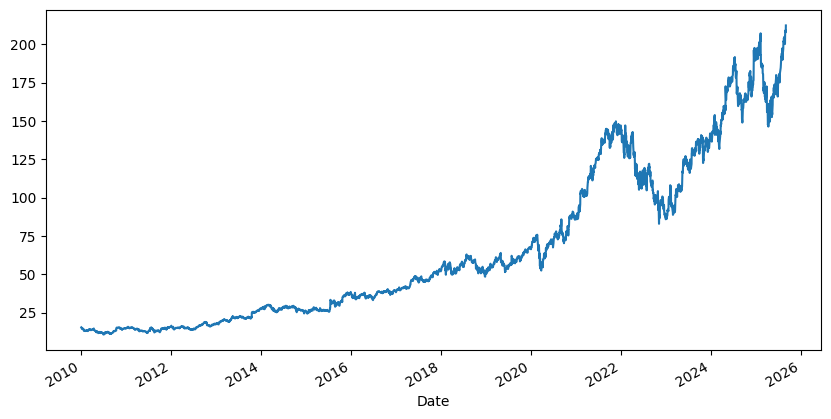

In [8]:
data['Close'].plot(figsize=(10,5))

In [9]:
#We will predict based on close price for stocks
new_data = data['Close']
new_data.shape

(3938,)

In [10]:
#Scale the data
scaler = MinMaxScaler()
sc_data = scaler.fit_transform(np.array(new_data).reshape(-1,1))

#Split data into train and test
train = sc_data[:int(0.8*len(sc_data))] #80%
test = sc_data[int(0.8*len(sc_data)):] #20%

print(len(train), len(test))
# sc_data

3150 788


In [11]:
#Convert an array of values into a dataset matrix

# dataX[i] = [dataX[i], dataX[i+1], dataX[i+2], ...., dataX[i+time_step]]
# dataY[i] = dataX[i+time_step+1]
# Use previous time_step values (X) as training features and (time_step+1)th value (Y) as label

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [12]:
#We will use previous 100 values as lags/traaining features
timestamps = 100
x_train, y_train = create_dataset(train, timestamps)
x_test, y_test = create_dataset(test, timestamps)

In [13]:
print(x_train.shape, x_test.shape)

(3049, 100) (687, 100)


In [14]:
#Define LSTM model and train on training data
model = Sequential([
    InputLayer(input_shape=(x_train.shape[1],1)),
    LSTM(256,return_sequences=True),
    Dropout(0.3),
    LSTM(256,return_sequences=False),
    Dropout(0.3),
    Dense(32),
    Dense(1)
])

model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()
model.fit(x_train,y_train,epochs=5,batch_size=32,verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 256)       │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,761 (3.04 MB)

 Trainable params: 797,761 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 761ms/step - loss: 0.0051
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 757ms/step - loss: 3.6156e-04
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 756ms/step - loss: 4.1677e-04
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 750ms/step - loss: 3.5987e-04
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 744ms/step - loss: 3.3839e-04


In [15]:
#Predict for test input
lstm_output = []
for i in range(len(x_test)):
  x_input = x_test[i].reshape(1,-1)
  y_pred = model.predict(x_input,verbose=0)
  lstm_output.append(y_pred[0][0])

#Rescale to original values again
rescaled_predict = scaler.inverse_transform(np.array(lstm_output).reshape(-1,1))
rescaled_test = scaler.inverse_transform(y_test.reshape(-1,1))

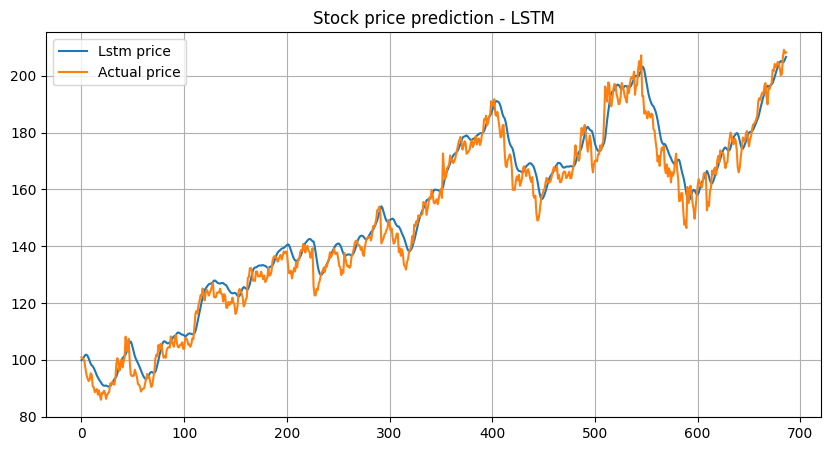

In [16]:
#Plot predictions
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(True)
plt.plot(rescaled_predict,label='Lstm price')
plt.plot(rescaled_test,label='Actual price')
plt.legend(loc="upper left")
plt.title("Stock price prediction - LSTM")
plt.show()

In [18]:
# Calculate MSE for LSTM model
mse_lstm = mean_squared_error(rescaled_test, rescaled_predict)
print(f"Mean Squared Error for LSTM model: {mse_lstm}")

Mean Squared Error for LSTM model: 26.088602010671167


In [19]:
rmse_lstm = np.sqrt(mse_lstm)
print(f"Root Mean Squared Error for LSTM model: {rmse_lstm}")

Root Mean Squared Error for LSTM model: 5.107700266330354


In [20]:
#Linear regression model
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

# Make predictions using the linear regression model
linear_predictions = linear_model.predict(x_test)

#Rescale to original values again
rescaled_linear_predictions = scaler.inverse_transform(linear_predictions.reshape(-1, 1))
rescaled_test_values = scaler.inverse_transform(y_test.reshape(-1, 1))

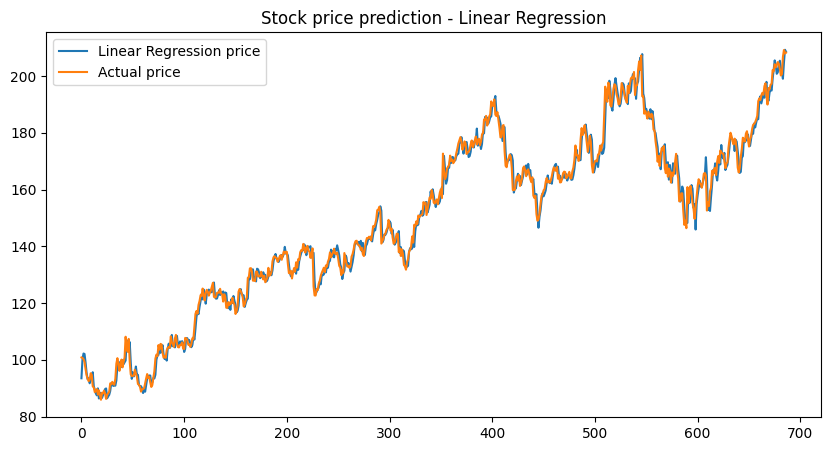

In [21]:
#Plot predictions
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(rescaled_linear_predictions,label='Linear Regression price')
plt.plot(rescaled_test_values,label='Actual price')
plt.legend(loc="upper left")
plt.title("Stock price prediction - Linear Regression")
plt.show()

In [22]:
# Calculate MSE for Linear Regression model
mse_linear = mean_squared_error(rescaled_test_values, rescaled_linear_predictions)
print(f"Mean Squared Error for Linear Regression model: {mse_linear}")

Mean Squared Error for Linear Regression model: 9.16406179584948


In [23]:
#Linear regression with another approach
df = data.copy()
df.columns = [col[0] for col in df.columns]

<Figure size 800x800 with 0 Axes>

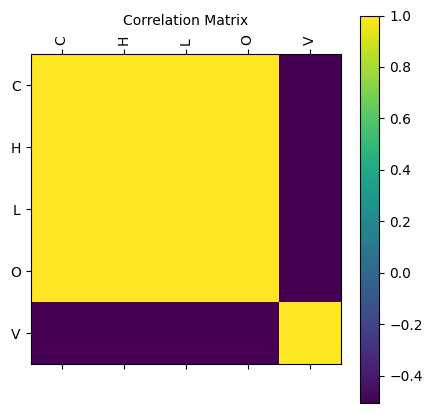

In [24]:
#See how much correlation is there between different features
plt.figure(figsize=(8,8))
plt.matshow(df.corr())
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10);

In [26]:
#Partition data into train and test
train_df = df[:int(0.8*len(df))]
test_df = df[int(0.8*len(df)):]
# train_df

In [27]:
#train features and labels
x_tr = train_df.drop(['C'],axis=1)
y_tr = train_df['C']
x_te = test_df.drop(['C'],axis=1)
y_te = test_df['C']

In [28]:
print(x_tr.shape)
print(x_te.shape)

(3150, 4)
(788, 4)


In [29]:
#Linear regression model
lin_reg = LinearRegression()
lin_reg.fit(x_tr,y_tr)

LinearRegression()

In [30]:
#Make predictions on test data
y_pred = lin_reg.predict(x_te)

In [31]:
#Observe relation between actual and predicted values
dfr = pd.DataFrame(columns=['Actual','Predicted'])
dfr['Actual'] = y_te
dfr['Predicted'] = y_pred

In [32]:
dfr.describe()

,Actual,Predicted
count,788.000000,788.000000
mean,143.431806,143.478394
std,32.934588,32.916661
min,82.996651,83.674678
25%,116.122250,116.282309
50%,141.871696,141.697385
75%,170.181000,170.204770
max,212.369995,211.688404


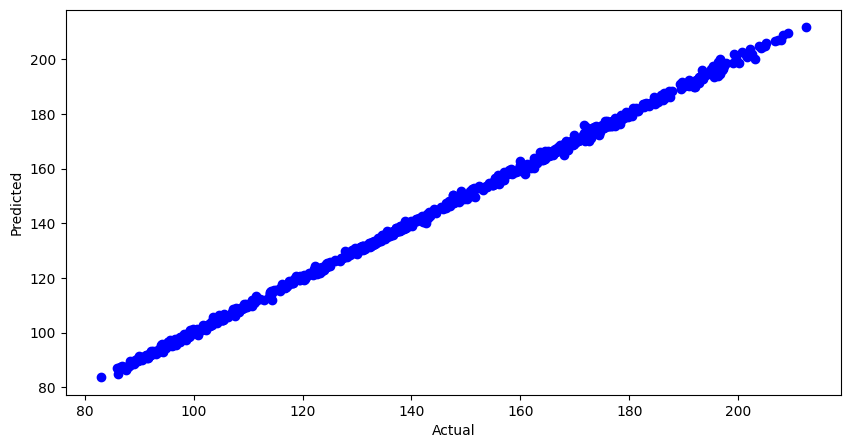

In [33]:
#Plot to know whether prediction and actual values are consistent
#A 45 degree straight line shows high accuracy
plt.scatter(y_te,y_pred,color='blue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()